# **PEML MLP Architecture 1 - computing physics output and feed in NN with regularisation**
## Experiment 1: y_phy calculated by linear time shifting according to wind speed and dist
### Only 2017 data

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline_2017.pth``


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
## all other variables are defined in config.py

In [7]:
# Change this according to the data you want to use
# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "LinearShift_MSE"
NN_TYPE = "MLP" # choose from "MLP", "RNN", "LSTM", "GRU"
torch.random.manual_seed(34)

In [8]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using 2017
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017/pollutants_minmax_2017.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017
MODEL_PATH_NAME:  best_MLP_no2_LinearShift_MSE_2017.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_LinearShift_MSE_2017.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_LinearShift_MSE_2017.txt
PLOT_FILENAME:  plot_MLP_no2_LinearShift_MSE_2017.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD   FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000       0.223698   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632       0.145496   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000       0.275978   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000       0.423742   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263       0.478721   
 ...                       ...  ...       ...       ...            ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526       0.606502   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053       0.456470   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158       0.483258   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263       0.468784   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105263       0.473428   
 
                      NO2_TUINDORP  

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [12]:
train_dataset.u

[                           DD   FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000       0.223698   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632       0.145496   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000       0.275978   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000       0.423742   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263       0.478721   
 ...                       ...  ...       ...       ...            ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526       0.606502   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053       0.456470   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158       0.483258   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263       0.468784   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105263       0.473428   
 
                      NO2_TUINDORP  

In [13]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [14]:
len(train_dataset.pairs[0][0])

72

In [15]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2237, 0.2421, 0.5630, 0.0000, 0.5367,
         0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.1455, 0.2232, 0.5707, 0.0000, 0.5467,
         0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2760, 0.1659, 0.5604, 0.0000, 0.5067,
         0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.4237, 0.1424, 0.5553, 0.0000, 0.4633,
         0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.4787, 0.1563, 0.5553, 0.0000, 0.4933,
         0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.4837, 0.3135, 0.5681, 0.3000, 0.6200,
         0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.4271, 0.5326, 0.5913, 0.0000, 0.6433,
         0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.4223, 0.5367, 0.5938, 0.0000, 0.6500,
         0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.3724, 0.5172, 0.5964, 0.0000, 0.6733,
         0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4429, 0.4459, 0.5990, 0.3000, 0.7133,
         0.6157],
        [0

In [16]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [17]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== NO2_TUINDORP_IDX
assert column_names.index('NO2_BREUKELEN') == NO2_BREUKELEN_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [18]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2_TUINDORP, Length: 2592, dtype: float64

In [19]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.223698
2017-08-01 01:00:00    0.145496
2017-08-01 02:00:00    0.275978
2017-08-01 03:00:00    0.423742
2017-08-01 04:00:00    0.478721
                         ...   
2017-11-16 19:00:00    0.606502
2017-11-16 20:00:00    0.456470
2017-11-16 21:00:00    0.483258
2017-11-16 22:00:00    0.468784
2017-11-16 23:00:00    0.473428
Name: NO2_BREUKELEN, Length: 2592, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

## Tuning Hyperparamters

In [22]:
print("tuning with loss function: ", LOSS_FUNC)
print("tuning with nn type: ", NN_TYPE)

tuning with loss function:  LinearShift_MSE
tuning with nn type:  MLP


In [ ]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64]) 
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _ = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, lambda_phy=lambda_phy, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_linearshift_mse_2017", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=50)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [38]:
print("Best Hyperparameters for baseline mlp 2017:", best_params)

Best Hyperparameters for baseline mlp 2017: {'n_hidden_layers': 2, 'n_hidden_units': 187, 'lr': 0.0016484583833793476, 'weight_decay': 7.42786315058395e-05, 'batch_size': 16, 'lambda_phy': 4.4126628878777386e-05}


In [27]:
BESTPARAMS_FILENAME

'best_params_MLP_no2_LinearShift_MSE_2017.txt'

### Save the params to a file

In [35]:
import json

file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

with open(file_path, "w") as f:
    json.dump(best_params, f, indent=4)  # Pretty format for readability

print(f"Best Hyperparameters saved to {file_path}")


Best Hyperparameters saved to /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_LinearShift_MSE_2017.txt


### Read params from file

In [36]:
with open(file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters:", best_params)


Loaded Best Parameters: {'n_hidden_layers': 2, 'n_hidden_units': 187, 'lr': 0.0016484583833793476, 'weight_decay': 7.42786315058395e-05, 'batch_size': 16, 'lambda_phy': 4.4126628878777386e-05}


In [39]:
torch.manual_seed(34)
# Train the model with the best hyperparameters
best_model_baseline = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time = best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], lambda_phy= best_params["lambda_phy"], device=device)

print(f"Training time: {training_time}")
# Save the trained model
torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

Epoch 1/50
Epoch 1/50 - Train Loss: 0.053642 - Val Loss (simple RMSE, no physics involved): 0.191549
Epoch 2/50
Epoch 2/50 - Train Loss: 0.025836 - Val Loss (simple RMSE, no physics involved): 0.174012
Epoch 3/50
Epoch 3/50 - Train Loss: 0.021295 - Val Loss (simple RMSE, no physics involved): 0.158117
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018058 - Val Loss (simple RMSE, no physics involved): 0.149304
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015850 - Val Loss (simple RMSE, no physics involved): 0.143405
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013675 - Val Loss (simple RMSE, no physics involved): 0.146197
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013666 - Val Loss (simple RMSE, no physics involved): 0.135139
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013004 - Val Loss (simple RMSE, no physics involved): 0.133463
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012648 - Val Loss (simple RMSE, no physics involved): 0.132407
Epoch 10/50
Epoch 10/50 - Train Loss: 0.012630 - Val Loss (simple RMSE, no physics involved

In [40]:
torch.manual_seed(34)  # Set seed for reproducibility
best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 140.279817
Test RMSE Loss: 12.686144
Test SMAPE Loss: 34.883498%
Total Inference Time: 0.05 seconds


In [41]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_LinearShift_MSE_2017.csv in Results/metrics folder


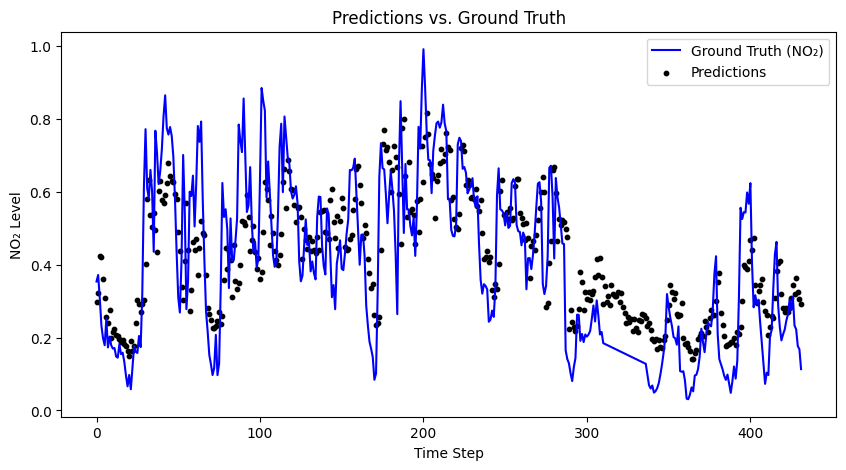

In [42]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model_baseline.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model_baseline(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
#save the plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
